In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import trange
import multiprocessing as mlp
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from tqdm import trange

In [3]:
plt.rcParams['figure.figsize'] = (20,10)

# Data Understanding and Data Pre-Proccessing

In [4]:
data = pd.read_csv('EUR_USD_M30_Output_Since_2005.csv')

In [5]:
data.head(5)

,DateTime,Volume,Open,High,Low,Close
0,2005-01-02T18:00:00.000000000Z,1,1.3560,1.3560,1.3560,1.3560
1,2005-01-02T18:30:00.000000000Z,5,1.3560,1.3568,1.3560,1.3567
2,2005-01-02T19:00:00.000000000Z,32,1.3569,1.3570,1.3556,1.3556
3,2005-01-02T19:30:00.000000000Z,12,1.3556,1.3565,1.3556,1.3558
4,2005-01-02T20:00:00.000000000Z,27,1.3559,1.3561,1.3556,1.3558


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166972 entries, 0 to 166971
Data columns (total 6 columns):
DateTime    166972 non-null object
Volume      166972 non-null int64
Open        166972 non-null float64
High        166972 non-null float64
Low         166972 non-null float64
Close       166972 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.6+ MB


In [7]:
data.isnull().sum() 

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [8]:
data.isna().sum()

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [9]:
data = data.iloc[:,[0,2,5]]

In [10]:
data.DateTime = pd.to_datetime(data.DateTime)

In [11]:
data.head(5)

,DateTime,Open,Close
0,2005-01-02 18:00:00,1.3560,1.3560
1,2005-01-02 18:30:00,1.3560,1.3567
2,2005-01-02 19:00:00,1.3569,1.3556
3,2005-01-02 19:30:00,1.3556,1.3558
4,2005-01-02 20:00:00,1.3559,1.3558


In [12]:
# data['diff'] = (data.iloc[:,2] - data.iloc[:,1])

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


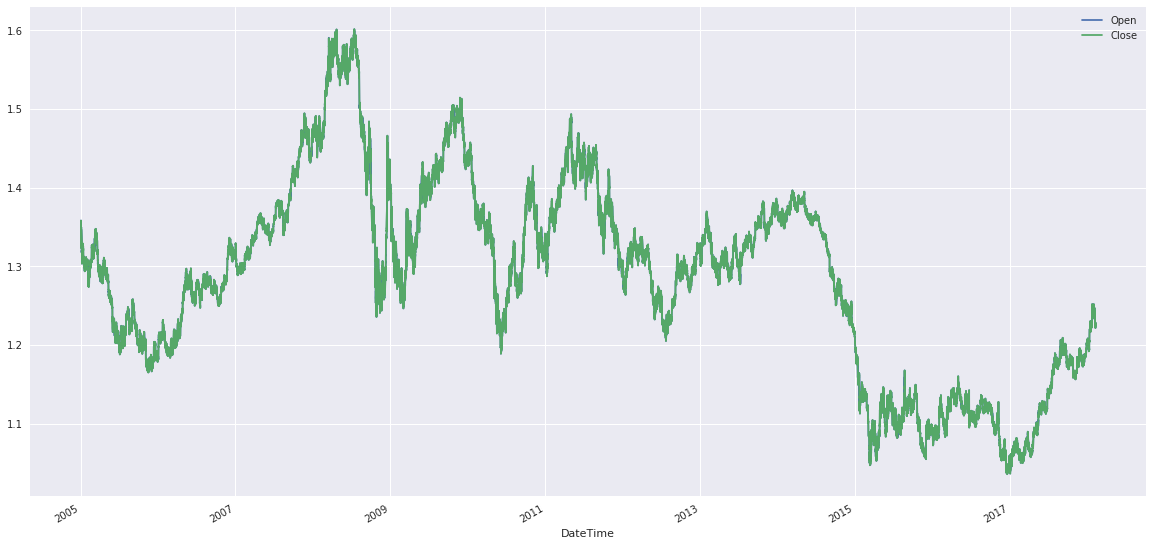

In [13]:
# plt.plot(range(len(data)) , data.iloc[: , 1])
data.plot(x='DateTime', y=['Open', 'Close'])

open and close price seem to be so close , so we would need one of them.

In [14]:
data = data.iloc[:, [0,2]]
data = data.rename(columns={'Close': 'Value'})

# Hyper Parameters

In [15]:
P = 12             # how many points to use for calulations
F = 10             # gap between last point and start range of measuring outcome of pattern
H = 75             # how similar recognized patters should be
Max_sim = 250      # maximum number of allowed selected similar pattern
Min_sim = 20       # minimum number of allowed selected similar pattern

# calculate diffrence in default length 

*** this difference is kind of normalized in the whole project and it's gonna be used anywhere difference measurement needed***

In [16]:
def percent_change(start_p, current_p):
    try:
        x = ((current_p - start_p) / abs(start_p)) * 100
        if x == 0:
            return 1e-10
        else:
            return x
    except Exception as e:
        return 1e-10

In [17]:
percent_change(data.iloc[0,1] , data.iloc[1,1])

0.05162241887905036

# Pattern Recognizer

In [18]:
x = len(data) - (P+F)
y = P + 1
pattern_ar = []
performance_ar =[]

for y in trange(P+1, x):
    tmp_pattern = []
    for i in range(P-1, -1, -1):
        tmp_pattern.append(percent_change(data.Value[y-P], data.Value[y-i]))

    current_point = data.Value[y]
    outcome_range = data.Value[y+F : y+P+F]
    try:
        avrage_outcome = outcome_range.mean()
    except Exception as e:
        print(e)
        avrage_outcome = 1e-10
        
    future_outcome = percent_change(current_point, avrage_outcome)
    
    pattern_ar.append(tmp_pattern)
    performance_ar.append(future_outcome)
    
    
#     print('current :', current_point)
#     print('outcome :', avrage_outcome)
#     print('percent change outcome :', future_outcome, '%')
#     print('_______')
#     print(tmp_pattern)
#     break

pattern_ar = np.array(pattern_ar)
performance_ar = np.array(performance_ar)

100%|██████████| 166937/166937 [01:51<00:00, 1497.10it/s]


In [19]:
t = 35566
print(performance_ar[t])
print(pattern_ar[t])

0.06596461469593515
[-0.00705985 -0.11295765 -0.06212671 -0.15531678 -0.13272524 -0.19485195
 -0.22732728 -0.21885546 -0.24003502 -0.18073225 -0.12284145 -0.11013371]


In [20]:
len(performance_ar[performance_ar > 0])

83525

# Pattern Finder

In [21]:
def pattern_finder(d):
    pt = []
    d = list(d)
    for i in range(1, len(d)):
        pt.append(percent_change(d[0], d[i]))
    return np.array(pt)

# Similarity Checker

In [22]:
def sim_check(pat, h, verbos=True):
    if verbos == True:
        sim_pat_inx = []
        for p in trange(len(pattern_ar)):
            sim = []
            for i in range(P):
                sim.append(100 - abs(percent_change(pat[i], pattern_ar[p][i])))
            sim = np.array(sim)
            # max of how sim = 100
            how_sim = sim.mean()

        #     print(sim)
        #     print(how_sim)

            if how_sim >= h:
                sim_pat_inx.append([p, how_sim])
        print(len(sim_pat_inx), 'similar pattern found!')
    #     print(sim_pat_inx)
    else:
        sim_pat_inx = []
        for p in range(len(pattern_ar)):
            sim = []
            for i in range(P):
                sim.append(100 - abs(percent_change(pat[i], pattern_ar[p][i])))
            sim = np.array(sim)
            # max of how sim = 100
            how_sim = sim.mean()

        #     print(sim)
        #     print(how_sim)

            if how_sim >= h:
                sim_pat_inx.append([p, how_sim])
        print(len(sim_pat_inx), 'similar pattern found!')
    #     print(sim_pat_inx)        
    
    return sim_pat_inx

*** Ploting last pattern and similar patterns to that ***

In [23]:
def plot_pat_sim(pat=None, sim_ar=None, h=None, plot_current=True):
    if h is None:
        h = H
    # in case nothing passed to func default mode would be ploting last pattern (h is not necessary)
    if plot_current == True and pat is None and sim_ar is None:
        pat = pattern_finder(data.Value.iloc[y+F: y+P+1+F])
        sim_ar = sim_check(pat, h)
    # in case just a pattern passed to func, automaticaly similiar patterns array will be created and ploted
    elif pat is not None and sim_ar is None:
        sim_ar = sim_check(pat, h)
        plot_current = False
    # in case pattern and similar array passed to func
    elif pat is not None and sim_ar is not None:
        plot_current = False
        print(len(sim_ar), 'similar pattern found!')
    else:
        print('Input Error!!!')
    
    
    for i in range(len(sim_ar)):
        plt.plot(range(1,P+1), pattern_ar[sim_ar[i][0]], linewidth=1)

        tmp_performance = performance_ar[sim_ar[i][0]]
        # if statement is because if future performance is upper than current patterns' change line
        if tmp_performance > pat[-1]:
            pcolor = 'green'
        else:
            pcolor = 'red'
        plt.scatter(P+.5, performance_ar[sim_ar[i][0]], c=pcolor, alpha=0.5)

    predict_value = sum([performance_ar[s[0]] for s in sim_ar]) / len(sim_ar)
    plt.scatter(P+1 , predict_value, c='red')
    plt.plot(range(1,P+1), pat, c='red', linewidth=3)
    plt.show()

100%|██████████| 166937/166937 [00:04<00:00, 33893.23it/s]


82 similar pattern found!


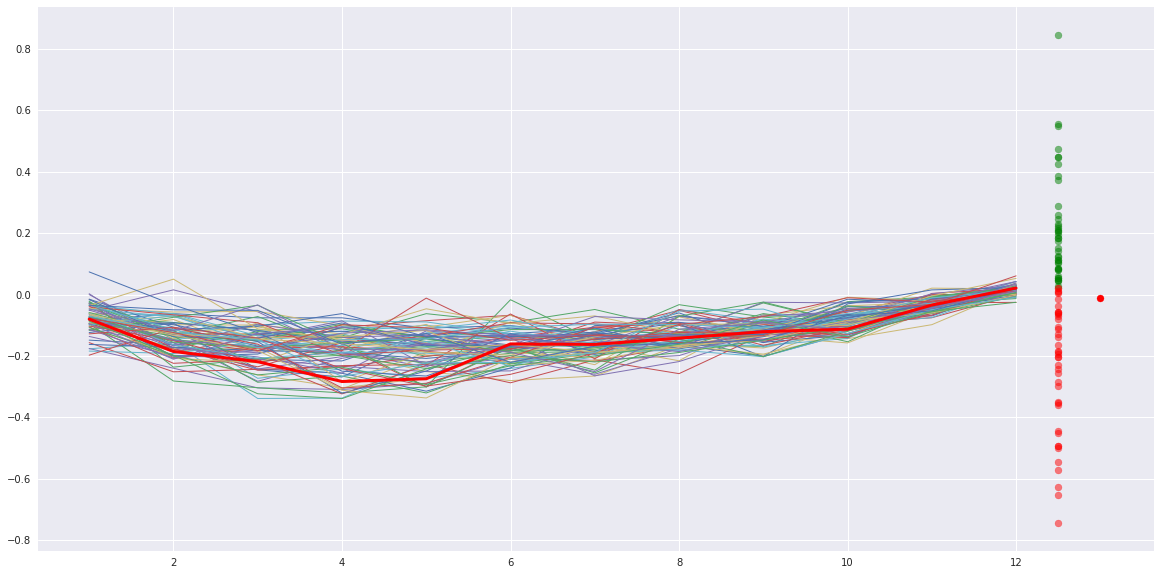

In [24]:
plot_pat_sim(h=60)

# Predictor

In [25]:
predicted_values_ar = []
tmp_pat = []
tmp_sim_pat_inx = []

def predictor(t):
    tmp_data = list(data.Value)
    last_used_point = y
    global predicted_values_ar, tmp_pat, tmp_sim_pat_inx
    predicted_values_ar = []
    tmp_pat = []
    tmp_sim_pat_inx = []
    
    T = pd.to_datetime(t)
    t_delta = T - data.DateTime[last_used_point]
    m = int(((t_delta.total_seconds() / 3600) * 2) - P - F)
    print('total points :', m)
    
    h = H
    for i in trange(1, m+1):
        tmp_pat.append(pattern_finder(tmp_data[last_used_point+i : last_used_point+i+P+1]))
        print('point number', i, ':')
        
        tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
        while len(tmp_sim_pat_inx[-1]) > Max_sim or len(tmp_sim_pat_inx[-1]) < Min_sim:
            while len(tmp_sim_pat_inx[-1]) < Min_sim:
                h -= 3
                print('how sim changed to',h)
                tmp_sim_pat_inx.pop(-1)
                tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
            while len(tmp_sim_pat_inx[-1]) > Max_sim:
                h += 3
                print('how sim changed to',h)
                tmp_sim_pat_inx.pop(-1)
                tmp_sim_pat_inx.append(sim_check(tmp_pat[-1], h, verbos=False))
                
        pred_change = sum([performance_ar[s[0]] for s in tmp_sim_pat_inx[-1]]) / len(tmp_sim_pat_inx[-1])
        predicted_values_ar.append(pred_change + tmp_data[last_used_point+i])
        tmp_data.append(predicted_values_ar[-1])
        
    return predicted_values_ar[-1]


# predictor('2018-02-10 00:30:00')
    

In [26]:
predictor('2018-02-10 8:30:00')

# predictor('2018-02-16 01:30:00')
# 1.2539

# predictor('2018-03-20 8:30:00')
# 1.2266

  0%|          | 0/22 [00:00<?, ?it/s]

total points : 22
point number 1 :
0 similar pattern found!
how sim changed to 72
0 similar pattern found!
how sim changed to 69
0 similar pattern found!
how sim changed to 66
0 similar pattern found!
how sim changed to 63
0 similar pattern found!
how sim changed to 60
0 similar pattern found!
how sim changed to 57
0 similar pattern found!
how sim changed to 54
0 similar pattern found!
how sim changed to 51
0 similar pattern found!
how sim changed to 48
0 similar pattern found!
how sim changed to 45
0 similar pattern found!
how sim changed to 42
0 similar pattern found!
how sim changed to 39
1 similar pattern found!
how sim changed to 36
2 similar pattern found!
how sim changed to 33
2 similar pattern found!
how sim changed to 30
7 similar pattern found!
how sim changed to 27
9 similar pattern found!
how sim changed to 24
16 similar pattern found!
how sim changed to 21


  5%|▍         | 1/22 [01:33<32:37, 93.20s/it]

29 similar pattern found!
point number 2 :


  9%|▉         | 2/22 [01:38<16:22, 49.15s/it]

229 similar pattern found!
point number 3 :
376 similar pattern found!
how sim changed to 24


 14%|█▎        | 3/22 [01:48<11:24, 36.01s/it]

231 similar pattern found!
point number 4 :
923 similar pattern found!
how sim changed to 27
655 similar pattern found!
how sim changed to 30
462 similar pattern found!
how sim changed to 33
310 similar pattern found!
how sim changed to 36


 18%|█▊        | 4/22 [02:12<09:57, 33.19s/it]

197 similar pattern found!
point number 5 :
17325 similar pattern found!
how sim changed to 39
14166 similar pattern found!
how sim changed to 42
11365 similar pattern found!
how sim changed to 45
8941 similar pattern found!
how sim changed to 48
6696 similar pattern found!
how sim changed to 51
4912 similar pattern found!
how sim changed to 54
3436 similar pattern found!
how sim changed to 57
2217 similar pattern found!
how sim changed to 60
1356 similar pattern found!
how sim changed to 63
791 similar pattern found!
how sim changed to 66
384 similar pattern found!
how sim changed to 69


 23%|██▎       | 5/22 [03:12<10:52, 38.40s/it]

177 similar pattern found!
point number 6 :
2090 similar pattern found!
how sim changed to 72
1297 similar pattern found!
how sim changed to 75
710 similar pattern found!
how sim changed to 78
315 similar pattern found!
how sim changed to 81


 27%|██▋       | 6/22 [03:35<09:35, 35.98s/it]

111 similar pattern found!
point number 7 :
1 similar pattern found!
how sim changed to 78
6 similar pattern found!
how sim changed to 75
16 similar pattern found!
how sim changed to 72


 32%|███▏      | 7/22 [03:55<08:25, 33.67s/it]

36 similar pattern found!
point number 8 :
538 similar pattern found!
how sim changed to 75


 36%|███▋      | 8/22 [04:05<07:10, 30.72s/it]

243 similar pattern found!
point number 9 :
0 similar pattern found!
how sim changed to 72
0 similar pattern found!
how sim changed to 69
0 similar pattern found!
how sim changed to 66
1 similar pattern found!
how sim changed to 63
1 similar pattern found!
how sim changed to 60
2 similar pattern found!
how sim changed to 57
6 similar pattern found!
how sim changed to 54
11 similar pattern found!
how sim changed to 51


 41%|████      | 9/22 [04:52<07:02, 32.51s/it]

24 similar pattern found!
point number 10 :
300 similar pattern found!
how sim changed to 54


 45%|████▌     | 10/22 [05:02<06:02, 30.24s/it]

202 similar pattern found!
point number 11 :


 50%|█████     | 11/22 [05:07<05:07, 27.95s/it]

41 similar pattern found!
point number 12 :
2 similar pattern found!
how sim changed to 51
9 similar pattern found!
how sim changed to 48


 55%|█████▍    | 12/22 [05:23<04:29, 26.97s/it]

39 similar pattern found!
point number 13 :


 59%|█████▉    | 13/22 [05:28<03:47, 25.29s/it]

103 similar pattern found!
point number 14 :


 64%|██████▎   | 14/22 [05:34<03:10, 23.87s/it]

84 similar pattern found!
point number 15 :
7 similar pattern found!
how sim changed to 45


 68%|██████▊   | 15/22 [05:43<02:40, 22.91s/it]

116 similar pattern found!
point number 16 :
0 similar pattern found!
how sim changed to 42
0 similar pattern found!
how sim changed to 39
0 similar pattern found!
how sim changed to 36
2 similar pattern found!
how sim changed to 33
16 similar pattern found!
how sim changed to 30


 73%|███████▎  | 16/22 [06:12<02:19, 23.29s/it]

40 similar pattern found!
point number 17 :
404 similar pattern found!
how sim changed to 33


 77%|███████▋  | 17/22 [06:22<01:52, 22.47s/it]

94 similar pattern found!
point number 18 :
1 similar pattern found!
how sim changed to 30
7 similar pattern found!
how sim changed to 27


 82%|████████▏ | 18/22 [06:35<01:27, 21.99s/it]

85 similar pattern found!
point number 19 :
0 similar pattern found!
how sim changed to 24
5 similar pattern found!
how sim changed to 21


 86%|████████▋ | 19/22 [06:49<01:04, 21.55s/it]

105 similar pattern found!
point number 20 :


 91%|█████████ | 20/22 [06:54<00:41, 20.71s/it]

117 similar pattern found!
point number 21 :
12 similar pattern found!
how sim changed to 18


 95%|█████████▌| 21/22 [07:03<00:20, 20.16s/it]

58 similar pattern found!
point number 22 :
18 similar pattern found!
how sim changed to 15


100%|██████████| 22/22 [07:12<00:00, 19.65s/it]

71 similar pattern found!


1.277391679740517

29 similar pattern found!


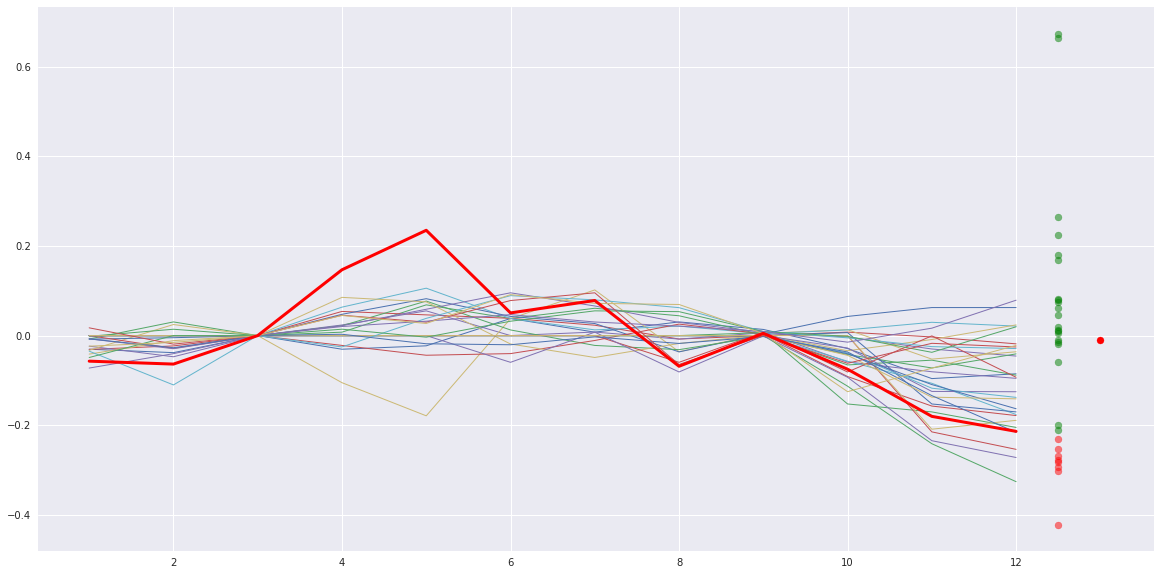

In [27]:
plot_pat_sim(pat=tmp_pat[0], sim_ar=tmp_sim_pat_inx[0])

In [28]:
pred_data_frame = pd.DataFrame(columns=['DateTime', 'Value'])
for i in range(len(predicted_values_ar)):
    t = data.DateTime.iloc[-1] + pd.Timedelta('{}min'.format(30*(i+1)))
    v = predicted_values_ar[i]
    pred_data_frame.loc[i] = [t, v]

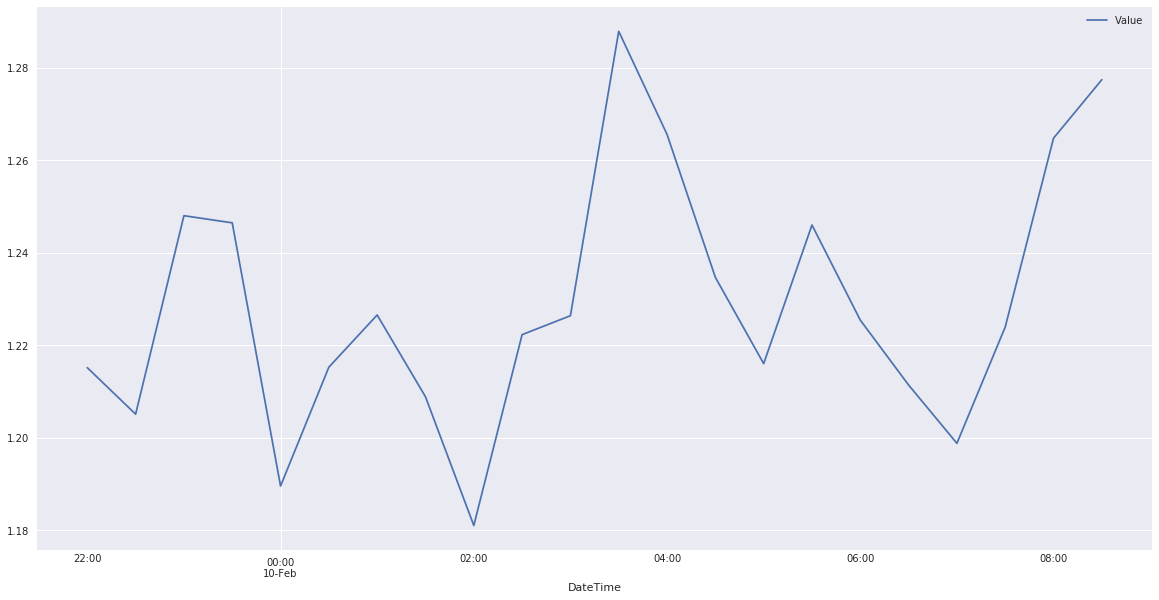

In [29]:
pred_data_frame.plot(x='DateTime', y='Value')

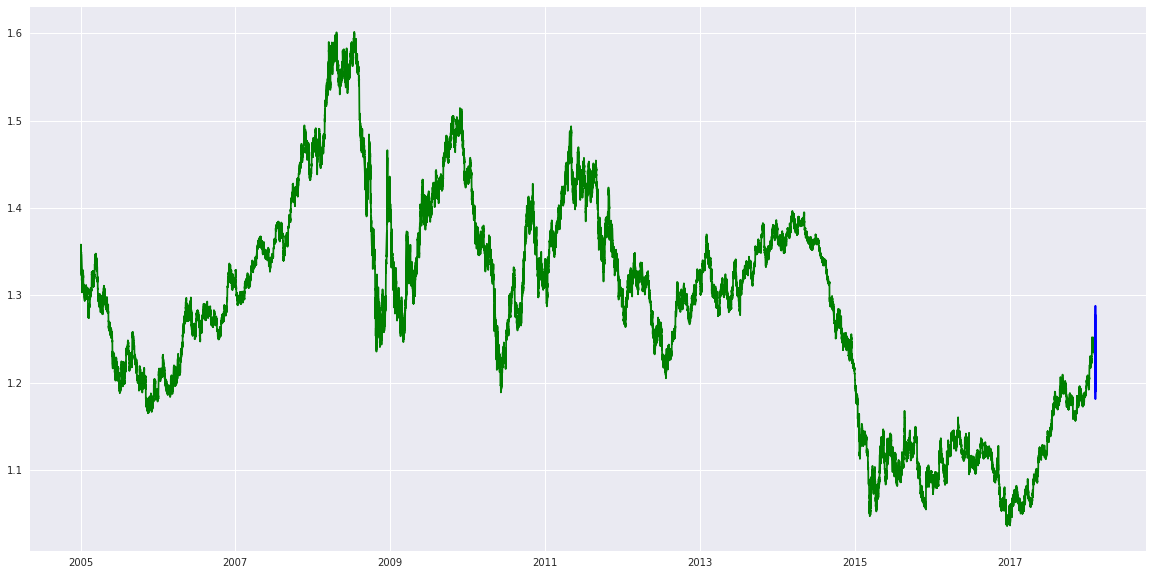

In [30]:
plt.plot(data.DateTime, data.Value, c='green')
plt.plot(pred_data_frame.DateTime, pred_data_frame.Value, c='blue')

In [ ]:
predictor('2018-02-16 01:30:00')
# 1.2539
pred_data_frame = pd.DataFrame(columns=['DateTime', 'Value'])
for i in range(len(predicted_values_ar)):
    t = data.DateTime.iloc[-1] + pd.Timedelta('{}min'.format(30*(i+1)))
    v = predicted_values_ar[i]
    pred_data_frame.loc[i] = [t, v]
pred_data_frame.plot(x='DateTime', y='Value')

In [ ]:
plt.plot(data.DateTime, data.Value, c='green')
plt.plot(pred_data_frame.DateTime, pred_data_frame.Value, c='blue')